In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/catboost-bax/df_bax_cleaned_to_view_outliers.csv


Training data shape: (2919, 5), (2919,)
Testing data shape: (730, 5), (730,)

Training CatBoost model...
Training complete.

Mean Absolute Error (MAE): 34.10
Root Mean Squared Error (RMSE): 41.54


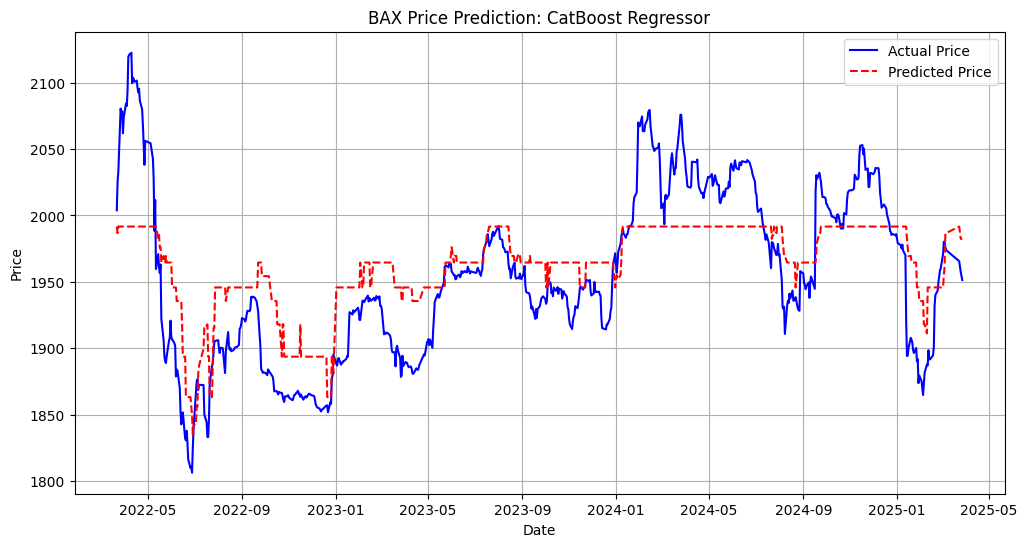

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the dataset
# Ensure the file 'df_bax_cleaned_to_view_outliers.csv' is in the same directory.
try:
    df = pd.read_csv('/kaggle/input/catboost-bax/df_bax_cleaned_to_view_outliers.csv')
except FileNotFoundError:
    print("Error: The file 'df_bax_cleaned_to_view_outliers.csv' was not found.")
    # Exiting the script if the file is not found.
    exit()

# --- 1. Data Preprocessing and Feature Engineering ---

# Convert 'Date' column to datetime objects and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select only the 'Price' column for our forecasting task
data = df[['Price']].copy()

# Create lagged features to convert the time series problem into a supervised learning problem.
# We will use the prices from the last 1, 2, 3, 5, and 10 days to predict the current day's price.
lags = [1, 2, 3, 5, 10]
for lag in lags:
    data[f'Price_lag_{lag}'] = data['Price'].shift(lag)

# Drop any rows with NaN values that were created by the lagging process.
data.dropna(inplace=True)

# Define the feature set (X) and the target variable (y)
X = data.drop('Price', axis=1)
y = data['Price']

# --- 2. Data Splitting ---

# Split the data in a time-based manner.
# We'll use the first 80% for training and the last 20% for testing.
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

# Check the shapes of the splits
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

# --- 3. Model Training ---

# Initialize and train the CatBoost Regressor model.
# CatBoost has robust default settings and often performs well without much tuning.
# The 'verbose=100' parameter prints the training progress every 100 iterations.
# 'early_stopping_rounds' helps prevent overfitting.
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.05,
    depth=6,
    loss_function='RMSE',
    random_state=42,
    verbose=0,
    early_stopping_rounds=50
)

print("\nTraining CatBoost model...")
cat_model.fit(X_train, y_train, eval_set=(X_test, y_test))
print("Training complete.")

# --- 4. Making Predictions ---

# Use the trained model to make predictions on the test data.
predictions = cat_model.predict(X_test)

# --- 5. Model Evaluation ---

# Calculate and print the evaluation metrics.
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"\nMean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- 6. Visualization ---

# Plot the actual vs. predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='blue')
plt.plot(y_test.index, predictions, label='Predicted Price', color='red', linestyle='--')
plt.title('BAX Price Prediction: CatBoost Regressor')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
